## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [57]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [59]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = "./homeworks/hw01_neural_machine_translation/data.txt"
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import utils
from utils import train, evaluate


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [61]:
tokenizer_W = WordPunctTokenizer()


def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [62]:
SRC = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

TRG = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data, format="tsv", fields=[("trg", TRG), ("src", SRC)]
)

In [63]:
# dataset, ff = dataset.split(split_ratio=0.01)

In [64]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05]) # type: ignore

In [65]:
print(f"Number of training examples: {len(train_data.examples)}")  # type: ignore
print(f"Number of validation examples: {len(valid_data.examples)}")  # type: ignore
print(f"Number of testing examples: {len(test_data.examples)}")  # type: ignore

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [66]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [67]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9232
Unique tokens in target (en) vocabulary: 6703


Here are tokens from original (RU) corpus:

In [68]:
SRC.vocab.itos[::10]  # ,skj 1000

['<unk>',
 'от',
 'услугам',
 'гости',
 '«',
 'экраном',
 'езды',
 'отеле',
 'душем',
 'находятся',
 'имеется',
 'полностью',
 '4',
 'во',
 'печью',
 'гостевой',
 'кабельными',
 'где',
 'косметическими',
 'доме',
 'кофе',
 '».',
 'отдохнуть',
 'нескольких',
 'номер',
 'утро',
 'холодильник',
 'вашим',
 'установлены',
 'установлена',
 'интернет',
 'напрокат',
 '40',
 'диваном',
 'курорта',
 'железнодорожный',
 'который',
 'чем',
 ')',
 'проживания',
 'ванные',
 's',
 'курортного',
 'плеер',
 'le',
 'воздухе',
 '45',
 'прачечная',
 'баров',
 '13',
 'площадь',
 'спальнями',
 'номерами',
 'самом',
 'дня',
 'велосипедные',
 'набережной',
 'светлые',
 'животными',
 'частной',
 'дороги',
 'центрального',
 'которые',
 '900',
 'ванными',
 'пляжей',
 'современной',
 'сада',
 'оснащен',
 'желающие',
 'собственные',
 '32',
 'плавательный',
 'обслуживанием',
 'панорамный',
 'проходит',
 'халаты',
 'современный',
 'выставочного',
 'обеденным',
 'каждых',
 'китайской',
 'приготовленные',
 'совещаний'

And from target (EN) corpus:

In [69]:
TRG.vocab.itos[::10]

['<unk>',
 '-',
 'away',
 'located',
 'room',
 'there',
 'it',
 'each',
 'accommodation',
 'enjoy',
 'dining',
 'hairdryer',
 'guest',
 '4',
 'de',
 'villa',
 'oven',
 'local',
 'resort',
 'refrigerator',
 'dishwasher',
 'laundry',
 'traditional',
 'its',
 'meals',
 'tour',
 'enjoyed',
 'continental',
 'internet',
 'both',
 'hire',
 'casa',
 'such',
 'del',
 ')',
 'options',
 'slippers',
 'bbq',
 'next',
 'regional',
 '700',
 'furnishings',
 'st',
 'along',
 'specialities',
 'maker',
 'hours',
 'meeting',
 'light',
 'simply',
 'simple',
 'safety',
 'church',
 'visit',
 'visiting',
 'lift',
 'assist',
 'common',
 'boutique',
 'temple',
 'charming',
 'arrangements',
 'blue',
 'split',
 'des',
 'bread',
 'playa',
 'tropical',
 'excursions',
 '00',
 'reachable',
 'travel',
 '250',
 'haus',
 'courts',
 '26',
 'casino',
 'black',
 'pousada',
 'seaside',
 'soundproofed',
 'hôtel',
 'heritage',
 'east',
 'pier',
 'sunny',
 'transfers',
 'adler',
 'premises',
 'comprises',
 'palm',
 'european',

And here is example from train dataset:

In [70]:
print(vars(train_data.examples[9]))

{'trg': ['yalta', 'is', '33', 'km', 'away', ',', 'while', 'simferepol', 'and', 'its', 'airport', 'are', '55', 'km', 'from', 'the', 'property', '.'], 'src': ['город', '-', 'курорт', 'ялта', 'находится', 'в', '33', 'км', 'от', 'мини', '-', 'гостиницы', '.', 'расстояние', 'до', 'города', 'симферополь', 'и', 'его', 'аэропорта', 'составляет', '55', 'км', '.']}


Let's check the length distributions:

Length distribution in Train data


(array([4.7600e+02, 8.6600e+03, 1.1105e+04, 8.7570e+03, 5.5650e+03,
        2.8670e+03, 1.4000e+03, 6.9100e+02, 2.6000e+02, 1.0900e+02,
        6.3000e+01, 2.8000e+01, 1.1000e+01, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <BarContainer object of 20 artists>)

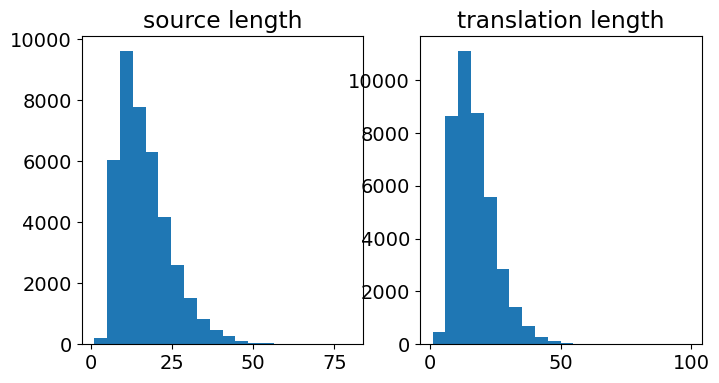

In [71]:
src_length = map(len, [vars(x)["src"] for x in train_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in train_data.examples])

print("Length distribution in Train data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

Length distribution in Test data


(array([5.240e+02, 1.161e+03, 1.765e+03, 1.107e+03, 1.194e+03, 6.060e+02,
        5.360e+02, 2.060e+02, 1.870e+02, 8.500e+01, 5.400e+01, 3.700e+01,
        1.100e+01, 1.000e+01, 6.000e+00, 6.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00]),
 array([ 4.  ,  7.45, 10.9 , 14.35, 17.8 , 21.25, 24.7 , 28.15, 31.6 ,
        35.05, 38.5 , 41.95, 45.4 , 48.85, 52.3 , 55.75, 59.2 , 62.65,
        66.1 , 69.55, 73.  ]),
 <BarContainer object of 20 artists>)

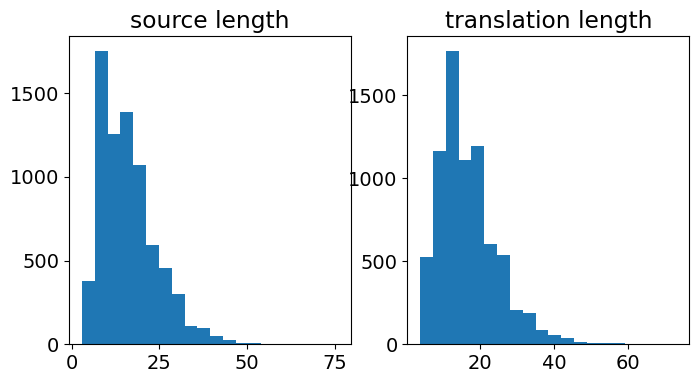

In [72]:
src_length = map(len, [vars(x)["src"] for x in test_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in test_data.examples])

print("Length distribution in Test data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [73]:
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [74]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [75]:
def _len_sort_key(x):
    return len(x.src)


BATCH_SIZE = 128 // 4 # 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key,
)

In [87]:
import my_network

Encoder = my_network.EncoderAndAttention
Decoder = my_network.DecoderAndAttention
Seq2Seq = my_network.Seq2SeqAndAttention
Attention = my_network.Attention

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
atn = Attention(HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, atn)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [88]:
# from torchinfo import summary

# sample = next(iter(train_iterator))
# summary(model, input_data=[sample.src, sample.trg])

In [89]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights)

Seq2SeqAndAttention(
  (encoder): EncoderAndAttention(
    (embedding): Embedding(9232, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAndAttention(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6703, 256)
    (rnn): LSTM(768, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=1280, out_features=6703, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [90]:
print(f"The model has {utils.count_parameters(model):,} trainable parameters")

The model has 21,596,207 trainable parameters


In [91]:
PAD_IDX = TRG.vocab.stoi["<pad>"]
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [92]:
train_history = []
valid_history = []

N_EPOCHS = 5
CLIP = 1

best_valid_loss = float("inf")

In [93]:
def run(n_epochs: int, clip_size: float):
    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train(
            model,
            train_iterator,
            optimizer,
            criterion,
            clip_size,
            train_history,
            valid_history,
        )
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = utils.epoch_time(start_time, end_time)

        # if valid_loss < best_valid_loss:
        #     best_valid_loss = valid_loss
        # torch.save(model.state_dict(), "tut1-model.pt")

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}"
        )
        print(
            f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}"
        )

In [94]:
run(N_EPOCHS, CLIP)

RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 2 but got size 32 for tensor number 1 in the list.

__Let's take a look at our network quality__:

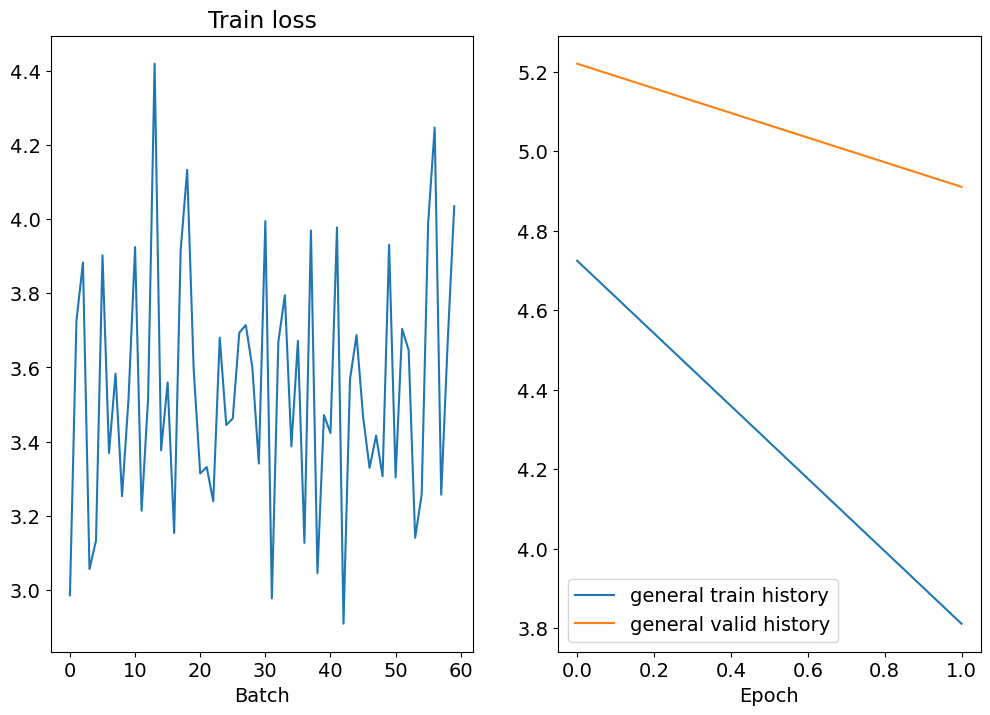

In [ ]:
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [ ]:
batch = next(iter(test_iterator))

In [ ]:
for idx in [1, 2]:
    src = batch.src[:, idx : idx + 1]
    trg = batch.trg[:, idx : idx + 1]
    generate_translation(src, trg, model, TRG.vocab)

Original: offering an outdoor pool , is 2 minutes ’ walk from de beach , in .
Generated: 

Original: city centre is the hotel located in the of , to the city shopping mall , and from the and centre .
Generated: 



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
# translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
# return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)  # turn off teacher forcing

        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend(
            [get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T]
        )

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

1it [00:00, 11.73it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

0

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points